In [1]:
import copy
import random
from collections import defaultdict

import numpy as np
import tqdm
from IPython import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

In [2]:
class RiverSwim:
    def __init__(self, current='WEAK', seed=1234):
        self.num_states = 6
        self.num_actions = 2  # O <=> LEFT, 1 <=> RIGHT

        # Larger current makes it harder to swim up the river
        self.currents = ['WEAK', 'MEDIUM', 'STRONG']
        assert current in self.currents
        self.current = self.currents.index(current) + 1
        assert self.current in [1, 2, 3]

        # Configure reward function
        R = np.zeros((self.num_states, self.num_actions))
        R[0, 0] = 0.005
        R[5, 1] = 0.6

        # Configure transition function
        T = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Encode initial and rewarding state transitions
        left, right = 0, 1
        T[0, left, 0] = 1.
        T[0, right, 0] = 0.4
        T[0, right, 1] = 0.6

        T[5, left, 4] = 1.
        T[5, right, 5] = 0.6
        T[5, right, 4] = 0.4

        # Encode intermediate state transitions
        for s in range(1, self.num_states - 1):
            # Going left always succeeds
            T[s, left, s - 1] = 1.

            # Going right sometimes succeeds
            T[s, right, s] = 0.6
            T[s, right, s - 1] = 0.05 * self.current
            T[s, right, s + 1] = 0.4 - 0.05 * self.current
            assert np.isclose(np.sum(T[s, right]), 1.)

        self.R = np.array(R)
        self.T = np.array(T)

        # Agent always starts at the opposite end of the river
        self.init_state = 0
        self.curr_state = self.init_state

        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_model(self):
        return copy.deepcopy(self.R), copy.deepcopy(self.T)

    def reset(self):
        return self.init_state

    def step(self, action):
        reward = self.R[self.curr_state, action]
        next_state = np.random.choice(np.arange(self.num_states), p=self.T[self.curr_state, action])
        self.curr_state = next_state
        return reward, next_state


In [3]:
# collect dataset
seed = 10
discount = 0.99
env = RiverSwim(seed=seed)

# uniform behavioral policy
behavioral_policy = np.ones([env.num_states, env.num_actions]) / env.num_actions

dataset = dict(observations=[], actions=[], next_observations=[], rewards=[])

# dataset size = 100K
num_episodes = 1000
max_episode_steps = 100
for _ in tqdm.trange(num_episodes):
    obs = env.reset()
    for step in range(max_episode_steps):
        action = np.random.choice(np.arange(env.num_actions), p=behavioral_policy[obs])
        reward, next_obs = env.step(action)
        
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['next_observations'].append(next_obs)
        dataset['rewards'].append(reward)
        
        obs = next_obs

train_dataset = {}
for k, v in dataset.items():
    if 'observations' in k or 'actions' in k:
        dtype = np.uint8
    else:
        dtype = np.float32
    train_dataset[k] = np.array(v, dtype=dtype)

100%|██████████| 1000/1000 [00:03<00:00, 250.09it/s]


In [4]:
# value iteration to find the optimal Q
rewards, transition_probs = env.get_model()

opt_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_q = rewards + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.num_states, env.num_actions])
opt_policy[np.arange(env.num_states), np.argmax(opt_q, axis=-1)] = 1.0


In [5]:
print(opt_q)
print(opt_policy)

[[22.49069248 22.71282068]
 [22.48569248 23.0951914 ]
 [22.86423949 23.81634368]
 [23.57818024 24.6067058 ]
 [24.36063874 25.42976492]
 [25.17546727 26.28124854]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


#### Utils

In [6]:
def sample_batch(batch_size):
    dataset_size = len(train_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], train_dataset)
    
    return batch

In [7]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

#### Q-learning

In [24]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs):
    obs = jax.nn.one_hot(obs, env.num_states)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(env.num_actions),
    ])(obs)

    return qs

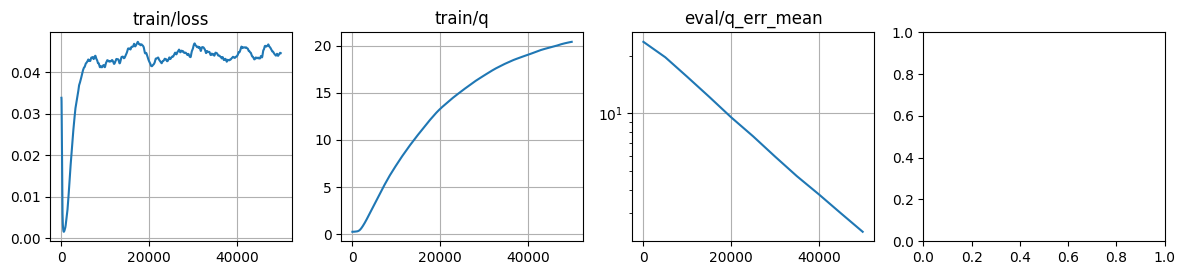

100%|██████████| 50000/50000 [00:53<00:00, 926.71it/s] 


In [25]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  qs = critic.apply(params, batch['observations'])
  q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.num_actions), axis=-1)
  
  next_qs = critic.apply(target_params, batch['next_observations'])
  next_q = jnp.max(next_qs, axis=-1)
  target_q = batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params):
  obs = jnp.arange(env.num_states)
  q = critic.apply(params, obs)
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  
  info = {
    'q_err_mean': q_err_mean
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [27]:
print(metrics['eval/q_err_mean'][-1])

[5.00000000e+04 2.40466189e+00]


#### C51

In [49]:
class CategoricalCritic(nn.Module):
  atoms: jnp.ndarray
  
  @nn.compact
  def __call__(self, obs):
    obs = jax.nn.one_hot(obs, env.num_states)

    num_atoms = len(self.atoms)

    logits = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(env.num_actions * num_atoms),
    ])(obs)
    
    logits = logits.reshape([obs.shape[0], env.num_actions, num_atoms])
    probs = jax.nn.softmax(logits, axis=-1)
    qs = jnp.sum(probs * self.atoms[None, None], axis=-1)

    return qs, probs

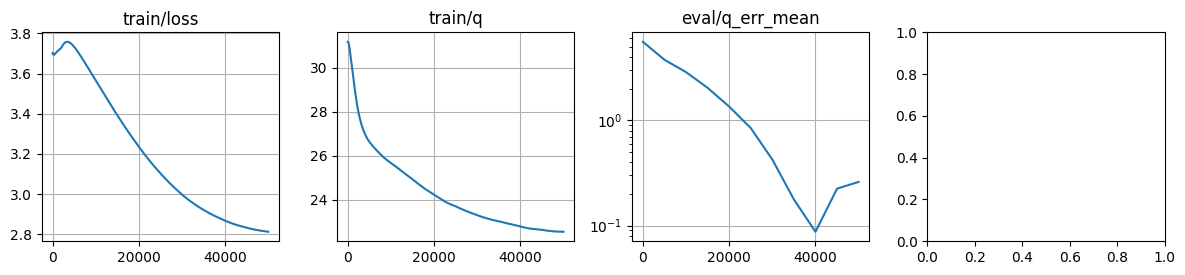

100%|██████████| 50000/50000 [00:59<00:00, 838.98it/s]


In [50]:
batch_size = 1024
tau = 0.005
num_atoms = 51
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards, _ = env.get_model()
v_min = rewards.min() / (1 - discount)
v_max = rewards.max() / (1 - discount)
atoms = jnp.linspace(v_min, v_max, num_atoms)
delta_atom = (v_max - v_min) / (num_atoms - 1)
offset = jnp.arange(batch_size, dtype=jnp.int32) * num_atoms
offset = offset[:, None]
offset = jnp.broadcast_to(offset, (batch_size, num_atoms))

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
cate_critic = CategoricalCritic(atoms)
cate_critic_params = cate_critic.init(critic_key, example_batch['observations'])
target_cate_critic_params = copy.deepcopy(cate_critic_params)

def loss_fn(params, target_params, batch):
  qs, dists = cate_critic.apply(params, batch['observations'])
  probs = jnp.sum(dists * jax.nn.one_hot(batch['actions'], env.num_actions)[..., None], axis=1)

  next_qs, next_dists = cate_critic.apply(target_params, batch['next_observations'])
  next_actions = jnp.argmax(next_qs, axis=-1)
  next_probs = jnp.sum(next_dists * jax.nn.one_hot(next_actions, env.num_actions)[..., None], axis=1)

  projected_atoms = jnp.clip(batch['rewards'][:, None] + discount * atoms[None], v_min, v_max)
  projected_bins = (projected_atoms - v_min) / delta_atom
  lower_bins = jnp.floor(projected_bins).astype(jnp.int32)
  upper_bins = jnp.ceil(projected_bins).astype(jnp.int32)

  delta_mass_lower = (upper_bins + (lower_bins == upper_bins).astype(jnp.int32) - projected_bins) * next_probs
  delta_mass_upper = (projected_bins - lower_bins) * next_probs
  
  mass = jnp.zeros(batch_size * num_atoms)
  mass = mass.at[(lower_bins + offset).ravel()].add(delta_mass_lower.ravel())
  mass = mass.at[(upper_bins + offset).ravel()].add(delta_mass_upper.ravel())
  mass = mass.reshape(batch_size, num_atoms)

  loss = jnp.sum(-mass * jnp.log(probs + 1e-8), axis=-1).mean()
  
  # logging
  q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.num_actions), axis=1)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(cate_critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params):
  obs = jnp.arange(env.num_states)
  q, _ = cate_critic.apply(params, obs)
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  
  info = {
    'q_err_mean': q_err_mean
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  cate_critic_params, target_cate_critic_params, opt_state, loss, info = update_fn(
    cate_critic_params, target_cate_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(cate_critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [51]:
print(metrics['eval/q_err_mean'][-1])

[5.00000000e+04 2.59948105e-01]


#### IQN

#### Flow distributional Q-learning

In [52]:
class CriticVectorField(nn.Module):
  @nn.compact
  def __call__(self, ret, time, obs):
    obs = jax.nn.one_hot(obs, env.num_states)
    inputs = jnp.concatenate([ret, time, obs], axis=-1)

    vector_field = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(env.num_actions),
    ])(inputs)
    
    vector_field = vector_field.reshape([obs.shape[0], env.num_actions])

    return vector_field

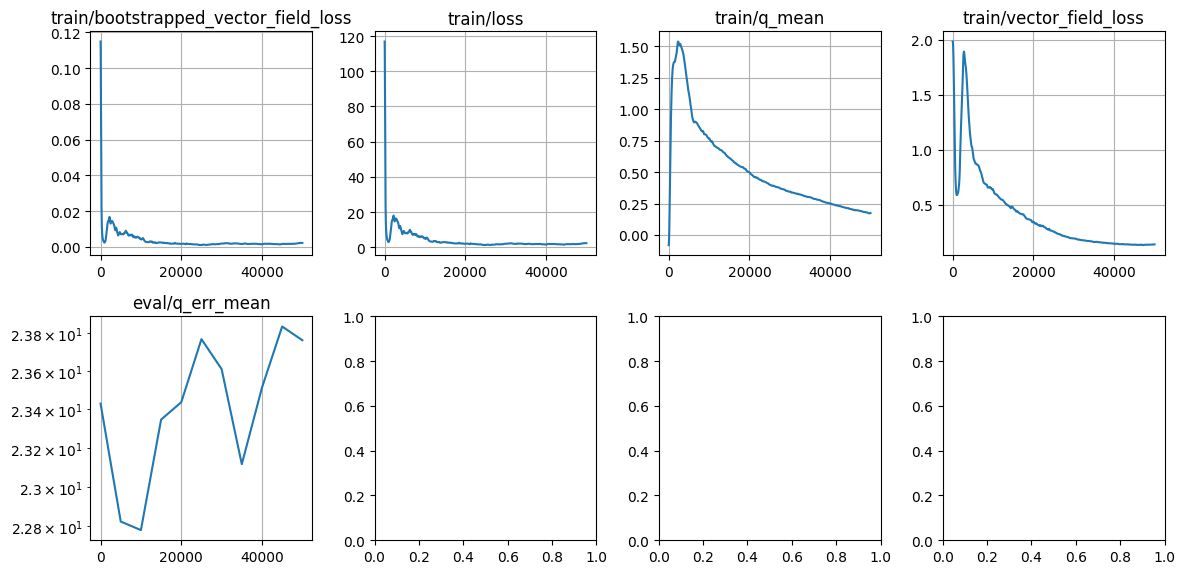

100%|██████████| 50000/50000 [03:06<00:00, 268.00it/s]


In [9]:
batch_size = 1024
tau = 0.005
# lam = 0.01
lam = 1000.0
num_flow_steps = 10
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards, _ = env.get_model()
min_reward = rewards.min()
max_reward = rewards.max()

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_vf_key = jax.random.split(key)

example_batch = sample_batch(2)
critic_vf = CriticVectorField()

ex_returns = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)
ex_times = jnp.ones((2, 1), dtype=example_batch['rewards'].dtype)

critic_vf_params = critic_vf.init(critic_vf_key, ex_returns, ex_times, example_batch['observations'])
target_critic_vf_params = copy.deepcopy(critic_vf_params)

@jax.jit
def compute_flow_returns(
  params,
  noises,
  observations,
  actions,
  init_times=None,
  end_times=None,
):
    """Compute returns from the return flow model using the Euler method."""
    noisy_returns = noises
    if init_times is None:
      init_times = jnp.zeros((*noisy_returns.shape[:-1], 1), dtype=noisy_returns.dtype)
    if end_times is None:
      end_times = jnp.ones((*noisy_returns.shape[:-1], 1), dtype=noisy_returns.dtype)
    step_size = (end_times - init_times ) / num_flow_steps

    def func(carry, i):
      """
      carry: (noisy_goals, )
      i: current step index
      """
      (noisy_returns, ) = carry

      times = i * step_size + init_times
      vector_field = critic_vf.apply(
        params, noisy_returns, times, observations)
      vector_field = jnp.sum(vector_field * jax.nn.one_hot(actions, env.num_actions)[..., None], axis=1)
      new_noisy_returns = noisy_returns + step_size * vector_field
      new_noisy_returns = jnp.clip(
        new_noisy_returns,
        min_reward / (1.0 - discount),
        max_reward / (1.0 - discount),
      )

      return (new_noisy_returns, ), None

    # Use lax.scan to do the iteration
    (noisy_returns, ), _ = jax.lax.scan(
        func, (noisy_returns,), jnp.arange(num_flow_steps))
    noisy_returns = jnp.clip(
      noisy_returns,
      min_reward / (1.0 - discount),
      max_reward / (1.0 - discount),
    )

    return noisy_returns

def loss_fn(params, target_params, batch, rng):
  rng, actor_rng, noise_rng, time_rng, q_rng = jax.random.split(rng, 5)
  
  # actor_noises = jax.random.normal(actor_rng, (batch_size, self.config['action_dim']))
  # next_actions = self.network.select('actor_onestep_flow')(batch['next_observations'], actor_noises)
  # next_actions = jnp.clip(next_actions, -1, 1)
  
  next_q_noises = jax.random.normal(actor_rng, (batch['next_observations'].shape[0], 1))
  next_qs = (next_q_noises[..., None] + critic_vf.apply(
    params, next_q_noises, jnp.zeros_like(next_q_noises), batch['next_observations']))
  next_actions = jnp.argmax(next_qs, axis=1).squeeze(-1)
  
  noises = jax.random.normal(noise_rng, (batch_size, 1))
  times = jax.random.uniform(time_rng, (batch_size, 1))
  # next_returns_left = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], jnp.zeros_like(batch['actions']))
  # next_returns_right = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], jnp.ones_like(batch['actions']))
  # next_returns = jnp.stack([next_returns_left, next_returns_right], axis=1)
  # next_returns = jnp.max(next_returns, axis=1)
  # next_actions = jnp.argmax(next_returns, axis=1)
  next_returns = compute_flow_returns(
    target_params, noises, batch['next_observations'], next_actions)
  # The following returns will be bounded automatically
  returns = jnp.expand_dims(batch['rewards'], axis=-1) + discount * next_returns
  noisy_returns = times * returns + (1.0 - times) * noises
  target_vector_field = returns - noises
  
  vector_fields = critic_vf.apply(params, noisy_returns, times, batch['observations'])
  vector_field = jnp.sum(vector_fields * jax.nn.one_hot(batch['actions'], env.num_actions)[..., None], axis=1)
  vector_field_loss = jnp.mean((vector_field - target_vector_field) ** 2)
  
  noisy_next_returns = compute_flow_returns(
    target_params, noises, batch['next_observations'], next_actions, end_times=times)
  transformed_noisy_returns = jnp.expand_dims(batch['rewards'], axis=-1) + discount * noisy_next_returns
  
  bootstrapped_vector_field = critic_vf.apply(
    params, transformed_noisy_returns, times, batch['observations'])
  bootstrapped_vector_field = jnp.sum(
    bootstrapped_vector_field * jax.nn.one_hot(batch['actions'], env.num_actions)[..., None], axis=1)
  target_bootstrapped_vector_field = critic_vf.apply(
    target_params, noisy_next_returns, times, batch['next_observations'])
  target_bootstrapped_vector_field = jnp.sum(target_bootstrapped_vector_field * jax.nn.one_hot(next_actions, env.num_actions)[..., None], axis=1)
  bootstrapped_vector_field_loss = jnp.mean((bootstrapped_vector_field - target_bootstrapped_vector_field) ** 2)
  
  loss = vector_field_loss + lam * bootstrapped_vector_field_loss
  
  # Additional metrics for logging.
  q_noises = jax.random.normal(q_rng, (batch['observations'].shape[0], 1))
  qs = (q_noises[..., None] + critic_vf.apply(
    params, q_noises, jnp.zeros_like(q_noises), batch['observations']))
  # q = compute_flow_returns(
    # params, q_noises, batch['observations'], batch['actions']).squeeze(-1)
  q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.num_actions)[..., None], axis=1).squeeze(-1)

  info = {
    'loss': loss,
    'vector_field_loss': vector_field_loss,
    'bootstrapped_vector_field_loss': bootstrapped_vector_field_loss,
    'q_mean': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_vf_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch, rng):
  (loss, info), grads = grad_fn(params, target_params, batch, rng)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params, rng):
  obs = jnp.arange(env.num_states)

  rng, q_rng = jax.random.split(rng)
  q_noises = jax.random.normal(q_rng, (obs.shape[0], 1))
  qs = (q_noises[..., None] + critic_vf.apply(
    params, q_noises, jnp.zeros_like(q_noises), obs))
  q = qs.squeeze(-1)
  # q1 = compute_flow_returns(
  #   params, q_noises, obs, jnp.zeros_like(obs)).squeeze(-1)
  # q2 = compute_flow_returns(
  #   params, q_noises, obs, jnp.ones_like(obs)).squeeze(-1)
  # q = jnp.stack([q1, q2], axis=-1)
  
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  
  info = {
    'q_err_mean': q_err_mean
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  key, train_key = jax.random.split(key)
  batch = sample_batch(batch_size)
  
  critic_vf_params, target_critic_vf_params, opt_state, loss, info = update_fn(
    critic_vf_params, target_critic_vf_params, opt_state, batch, train_key)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    key, eval_key = jax.random.split(key)
    eval_info = evaluate_fn(critic_vf_params, eval_key)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [34]:
print(metrics['eval/q_err_mean'][-1])

[5.00000000e+04 1.62734079e+00]


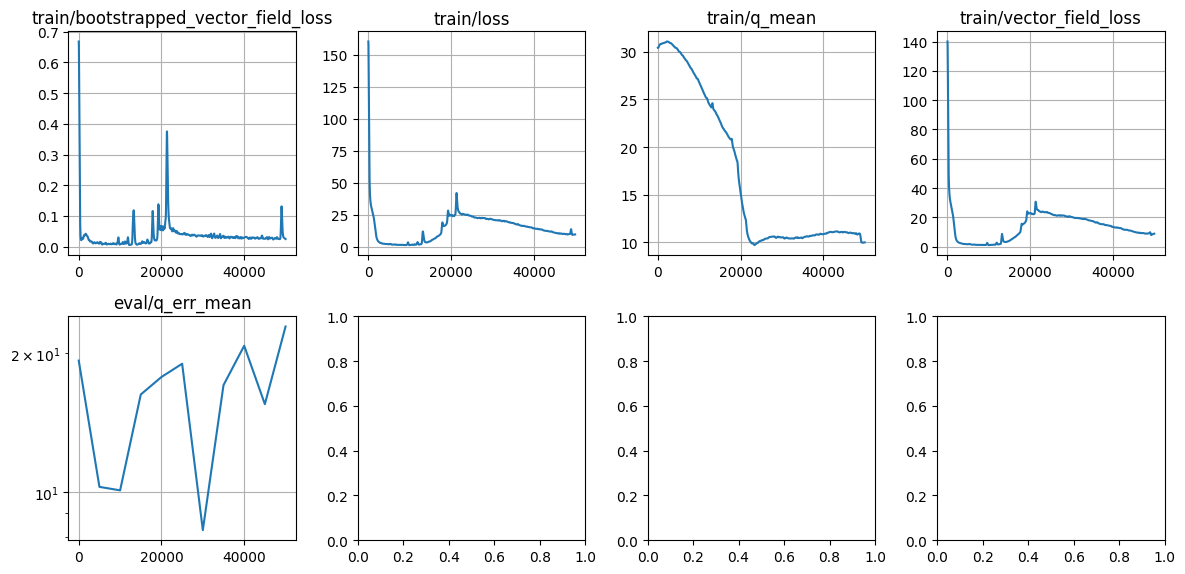

100%|██████████| 50000/50000 [03:57<00:00, 210.22it/s]


In [ ]:
batch_size = 1024
tau = 0.005
lam = 30
num_flow_steps = 10
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

rewards, _ = env.get_model()
min_reward = rewards.min()
max_reward = rewards.max()

key = jax.random.PRNGKey(np.random.randint(0, 2 ** 32))
key, critic_vf_key = jax.random.split(key)

example_batch = sample_batch(2)
critic_vf = CriticVectorField()

ex_returns = jnp.ones((2, env.num_actions), dtype=example_batch['rewards'].dtype)
ex_times = jnp.ones((2, env.num_actions), dtype=example_batch['rewards'].dtype)

critic_vf_params = critic_vf.init(critic_vf_key, ex_returns, ex_times, example_batch['observations'])
target_critic_vf_params = copy.deepcopy(critic_vf_params)

@jax.jit
def compute_flow_returns(
  params,
  noises,
  observations,
  init_times=None,
  end_times=None,
):
    """Compute returns from the return flow model using the Euler method."""
    noisy_returns = noises
    if init_times is None:
      init_times = jnp.zeros((*noisy_returns.shape[:-1], env.num_actions), dtype=noisy_returns.dtype)
    if end_times is None:
      end_times = jnp.ones((*noisy_returns.shape[:-1], env.num_actions), dtype=noisy_returns.dtype)
    step_size = (end_times - init_times) / num_flow_steps

    def func(carry, i):
      """
      carry: (noisy_goals, )
      i: current step index
      """
      (noisy_returns, ) = carry

      times = i * step_size + init_times
      vector_field = critic_vf.apply(
        params, noisy_returns, times, observations)
      # vector_field = jnp.sum(vector_field * jax.nn.one_hot(actions, env.num_actions)[..., None], axis=1)
      new_noisy_returns = noisy_returns + step_size * vector_field
      new_noisy_returns = jnp.clip(
        new_noisy_returns,
        min_reward / (1.0 - discount),
        max_reward / (1.0 - discount),
      )

      return (new_noisy_returns, ), None

    # Use lax.scan to do the iteration
    (noisy_returns, ), _ = jax.lax.scan(
        func, (noisy_returns,), jnp.arange(num_flow_steps))
    noisy_returns = jnp.clip(
      noisy_returns,
      min_reward / (1.0 - discount),
      max_reward / (1.0 - discount),
    )

    return noisy_returns

def loss_fn(params, target_params, batch, rng):
  rng, actor_rng, noise_rng, time_rng, q_rng = jax.random.split(rng, 5)
  
  next_q_noises = jax.random.uniform(actor_rng, (batch['next_observations'].shape[0], env.num_actions),
                                     minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  # next_qs = (next_q_noises[..., None] + critic_vf.apply(
  #   params, next_q_noises, jnp.zeros_like(next_q_noises), batch['next_observations']))
  next_returns = compute_flow_returns(
    params, next_q_noises, batch['next_observations'])
  next_actions = jnp.argmax(next_returns, axis=1)
  
  noises = jax.random.uniform(noise_rng, (batch_size, env.num_actions),
                              minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  times = jax.random.uniform(time_rng, (batch_size, env.num_actions))
  # next_returns_left = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], jnp.zeros_like(batch['actions']))
  # next_returns_right = compute_flow_returns(
  #   target_params, noises, batch['next_observations'], jnp.ones_like(batch['actions']))
  # next_returns = jnp.stack([next_returns_left, next_returns_right], axis=1)
  # next_returns = jnp.max(next_returns, axis=1)
  # next_actions = jnp.argmax(next_returns, axis=1)
  next_returns = compute_flow_returns(
    target_params, next_q_noises, batch['next_observations'])
  next_returns = jnp.sum(next_returns * jax.nn.one_hot(next_actions, env.num_actions), axis=-1)
  # The following returns will be bounded automatically
  returns = batch['rewards'] + discount * next_returns
  returns = jnp.clip(
    returns,
    min_reward / (1.0 - discount),
    max_reward / (1.0 - discount),
  )
  returns = jnp.repeat(returns[:, None], env.num_actions, axis=-1)
  noisy_returns = times * returns + (1.0 - times) * next_q_noises
  target_vector_field = returns - next_q_noises
  target_vector_field = jnp.sum(target_vector_field * jax.nn.one_hot(batch['actions'], env.num_actions), axis=1)
  
  vector_fields = critic_vf.apply(params, noisy_returns, times, batch['observations'])
  vector_field = jnp.sum(vector_fields * jax.nn.one_hot(batch['actions'], env.num_actions), axis=1)
  vector_field_loss = jnp.mean((vector_field - target_vector_field) ** 2)
  
  noisy_next_returns = compute_flow_returns(
    target_params, next_q_noises, batch['next_observations'], end_times=times)
  noisy_next_returns = jnp.sum(noisy_next_returns * jax.nn.one_hot(next_actions, env.num_actions), axis=1)
  transformed_noisy_returns = batch['rewards'] + discount * noisy_next_returns
  transformed_noisy_returns = jnp.clip(
    transformed_noisy_returns,
    min_reward / (1.0 - discount),
    max_reward / (1.0 - discount),
  )

  noisy_next_returns = jnp.repeat(noisy_next_returns[:, None], env.num_actions, axis=-1)
  transformed_noisy_returns = jnp.repeat(transformed_noisy_returns[:, None], env.num_actions, axis=-1)
  bootstrapped_vector_field = critic_vf.apply(
    params, transformed_noisy_returns, times, batch['observations'])
  bootstrapped_vector_field = jnp.sum(
    bootstrapped_vector_field * jax.nn.one_hot(batch['actions'], env.num_actions), axis=1)
  target_bootstrapped_vector_field = critic_vf.apply(
    target_params, noisy_next_returns, times, batch['next_observations'])
  target_bootstrapped_vector_field = jnp.sum(target_bootstrapped_vector_field * jax.nn.one_hot(next_actions, env.num_actions), axis=1)
  bootstrapped_vector_field_loss = jnp.mean((bootstrapped_vector_field - target_bootstrapped_vector_field) ** 2)
  
  loss = vector_field_loss + lam * bootstrapped_vector_field_loss
  
  # Additional metrics for logging.
  q_noises = jax.random.uniform(q_rng, (batch['observations'].shape[0], env.num_actions),
                                minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  # qs = (q_noises[..., None] + critic_vf.apply(
  #   params, q_noises, jnp.zeros_like(q_noises), batch['observations']))
  qs = compute_flow_returns(
    params, q_noises, batch['observations'])
  q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.num_actions), axis=1)

  info = {
    'loss': loss,
    'vector_field_loss': vector_field_loss,
    'bootstrapped_vector_field_loss': bootstrapped_vector_field_loss,
    'q_mean': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_vf_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch, rng):
  (loss, info), grads = grad_fn(params, target_params, batch, rng)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def evaluate_fn(params, rng):
  obs = jnp.arange(env.num_states)

  rng, q_rng = jax.random.split(rng)
  q_noises = jax.random.uniform(q_rng, (obs.shape[0], env.num_actions),
                                minval=min_reward / (1.0 - discount), maxval=max_reward / (1.0 - discount))
  # qs = (q_noises[..., None] + critic_vf.apply(
  #   params, q_noises, jnp.zeros_like(q_noises), obs))
  # q = qs.squeeze(-1)
  # q1 = compute_flow_returns(
  #   params, q_noises, obs, jnp.zeros_like(obs)).squeeze(-1)
  # q2 = compute_flow_returns(
  #   params, q_noises, obs, jnp.ones_like(obs)).squeeze(-1)
  # q = jnp.stack([q1, q2], axis=-1)
  q = compute_flow_returns(
    params, q_noises, obs)
  
  q_err_mean = jnp.mean(np.abs(q - opt_q))
  
  info = {
    'q_err_mean': q_err_mean
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  key, train_key = jax.random.split(key)
  batch = sample_batch(batch_size)
  
  critic_vf_params, target_critic_vf_params, opt_state, loss, info = update_fn(
    critic_vf_params, target_critic_vf_params, opt_state, batch, train_key)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    key, eval_key = jax.random.split(key)
    eval_info = evaluate_fn(critic_vf_params, eval_key)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [54]:
print(metrics['eval/q_err_mean'][-1])

[5.00000000e+04 2.28369045e+01]
